## Literature


https://greglandrum.github.io/rdkit-blog/posts/2024-05-31-scaffold-splits-and-murcko-scaffolds1.html

https://www.oloren.ai/blog/scaff-split

https://practicalcheminformatics.blogspot.com/2023/06/getting-real-with-molecular-property.html

In [117]:
import io

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
from rdkit import Chem
from rdkit.Chem import Draw, rdFMCS
from rdkit.Chem.Draw import IPythonConsole

# Set up RDKit drawing options
Draw.SetComicMode(IPythonConsole.drawOptions)

# Set up matplotlib
plt.style.use("tableau-colorblind10")
plt.rcParams["font.size"] = "16"

In [128]:
# Read the parquet file
parquet_file="../data/raw/enveda_library_subset_halfpercent.parquet"
df = pd.read_parquet(parquet_file)


# Assuming you have a DataFrame called 'df'
column_list = df.columns.tolist()

# Print the list of columns
print(column_list)

['precursor_mz', 'precursor_charge', 'mzs', 'intensities', 'in_silico', 'smiles', 'adduct', 'collision_energy', 'instrument_type', 'compound_class', 'entropy', 'scaffold_smiles']


In [129]:
print(f"Total molecules in original dataset: {len(df)}")



Total molecules in original dataset: 5193


In [130]:

print(f"Total molecules: {len(df) + len(failed_scaffold_df)}")
print(f"Molecules with valid scaffolds: {len(df)}")
print(f"Molecules that failed scaffold generation: {len(failed_scaffold_df)}")
# Count unique scaffolds
unique_scaffolds = df['scaffold_smiles'].nunique()
print(f"Number of unique scaffolds: {unique_scaffolds}")

Total molecules: 5193
Molecules with valid scaffolds: 5193
Molecules that failed scaffold generation: 0
Number of unique scaffolds: 2664


In [131]:
import pandas as pd
from rdkit import Chem
import pyarrow as pa
import pyarrow.parquet as pq

# Sort the DataFrame by scaffold frequency (descending) and then by scaffold_smiles
df_sorted = df_sorted.sort_values([ 'scaffold_smiles'], ascending=[ True])


# Verify the sorting
total_rows = len(df_sorted)
print(f"Total rows: {total_rows}")
print(f"90% mark: {int(total_rows * 0.9)}")
print("\nFirst 5 rows (most common scaffolds):")
print(df_sorted[['scaffold_smiles']].head())
print("\nLast 5 rows (least common scaffolds):")
print(df_sorted[['scaffold_smiles']].tail())

Total rows: 10386
90% mark: 9347

First 5 rows (most common scaffolds):
    scaffold_smiles
0                  
881                
880                
879                
878                

Last 5 rows (least common scaffolds):
      scaffold_smiles
10382        c1ncncn1
10375        c1ncncn1
10383      c1nnc[nH]1
10384         c1nncs1
10385         c1nncs1


In [132]:
def print_column_names(df):
    print("Column names of the DataFrame:")
    for col in df.columns:
        print(f"- {col}")

def print_nth_row(df, n):
    if n < 0 or n >= len(df):
        print(f"Error: Row index {n} is out of bounds. DataFrame has {len(df)} rows.")
        return
    
    print(f"Row {n} of the DataFrame:")
    row = df.iloc[n]
    for col, value in row.items():
        if col in ['mol', 'scaffold']:  # These are RDKit mol objects
            value = "RDKit Mol object"
        elif isinstance(value, str) and len(value) > 50:
            value = value[:47] + "..."
        print(f"{col}: {value}")

# Usage:
print_column_names(df)
print("\n")  # Add a blank line for readability
print_nth_row(df, 0)  # Print the first row (index 0)

# If you want to print a different row, just change the index:
print_nth_row(df, 1)  # This will print the 6th row (index 5)

Column names of the DataFrame:
- precursor_mz
- precursor_charge
- mzs
- intensities
- in_silico
- smiles
- adduct
- collision_energy
- instrument_type
- compound_class
- entropy
- scaffold_smiles


Row 0 of the DataFrame:
precursor_mz: 338.139
precursor_charge: 1.0
mzs: [ 65.039124  68.049843  70.065514  73.657387  80.897926  84.959824
  86.060242  88.07589   92.375031  93.033783  95.013153 104.279709
 105.033463 121.028519 131.012756 149.0233   152.062027 153.069778
 165.069672 166.077835 167.033829 167.085419 176.063385 177.069489
 178.077713 181.064407 194.072708 195.080322 205.064865 222.06749
 223.075165 247.383423 250.062866 251.069992 253.08493  297.614166
 338.138153 351.437958]
intensities: [5.38446617e-03 1.04719831e-03 7.14304466e-02 5.09743466e-04
 5.49852036e-04 6.31235971e-04 4.52249653e-03 8.23271576e-01
 8.49134895e-04 4.13380802e-03 8.63282281e-04 5.23745003e-04
 2.50556051e-02 8.57419137e-03 9.15131724e-03 2.68341503e-01
 1.37737206e-02 1.98457206e-03 9.01611489e-03 

# Sort data by scaffold smile

In [133]:

# Sort the DataFrame by scaffold_smiles
df_sorted = df.sort_values(by='scaffold_smiles', ascending=True)

# Reset the index of the sorted DataFrame
df_sorted = df_sorted.reset_index(drop=True)

# Print the first few rows of the sorted DataFrame
print("First few rows of the DataFrame sorted by scaffold_smiles:")
print(df_sorted[['scaffold_smiles', 'smiles']].head())

# Print the last few rows of the sorted DataFrame
print("\nLast few rows of the DataFrame sorted by scaffold_smiles:")
print(df_sorted[['scaffold_smiles', 'smiles']].tail())

# To see the distribution of scaffolds, you can count the occurrences:
scaffold_counts = df_sorted['scaffold_smiles'].value_counts()
print("\nTop 10 most common scaffolds:")
print(scaffold_counts.head(10))

# To get the number of unique scaffolds:
unique_scaffolds = df_sorted['scaffold_smiles'].nunique()
print(f"\nNumber of unique scaffolds: {unique_scaffolds}")



First few rows of the DataFrame sorted by scaffold_smiles:
  scaffold_smiles                                             smiles
0                                                          CCCC(=O)O
1                                             CC(C)CCCCCCCCCCCC(=O)O
2                                                        CCCCCC(=O)O
3                                       CCCCCC=CCC=CCCCCCCCC(=O)NCCC
4                  CCCCCC=CCC=CCC=CCC=CCCCCCC(=O)OC(COC(=O)CCCCCC...

Last few rows of the DataFrame sorted by scaffold_smiles:
       scaffold_smiles                         smiles
5188  c1ncnc(NC2CC2)n1  CSc1nc(NC2CC2)nc(NC(C)(C)C)n1
5189          c1ncncn1     CCNc1nc(=O)nc(NC(C)C)[nH]1
5190          c1ncncn1     CSc1nc(NC(C)C)nc(NC(C)C)n1
5191          c1ncncn1  CC(C)Nc1nc(=O)nc(NC(C)C)[nH]1
5192           c1nncs1     CC(=O)Nc1nnc(S(N)(=O)=O)s1

Top 10 most common scaffolds:
scaffold_smiles
                               675
c1ccccc1                       246
O=c1cc(-c2ccccc2)oc2ccccc12

# Split the data for train and test

In [134]:
import os
# Calculate the split point (90% of the data)
split_point = int(len(df) * 0.9)

# Split the DataFrame
df_90 = df_sorted.iloc[:split_point]
df_10 = df_sorted.iloc[split_point:]

# Create output directory if it doesn't exist
output_dir = "../data/processed"
os.makedirs(output_dir, exist_ok=True)

# Generate output file names
input_filename = os.path.basename(parquet_file)
output_90_filename = f"{os.path.splitext(input_filename)[0]}_90percent.parquet"
output_10_filename = f"{os.path.splitext(input_filename)[0]}_10percent.parquet"

# Full paths for output files
output_90_path = os.path.join(output_dir, output_90_filename)
output_10_path = os.path.join(output_dir, output_10_filename)

# Write to Parquet files
df_90.to_parquet(output_90_path, index=False)
df_10.to_parquet(output_10_path, index=False)

print(f"90% data written to '{output_90_path}' ({len(df_90)} rows)")
print(f"10% data written to '{output_10_path}' ({len(df_10)} rows)")

90% data written to '../data/processed/enveda_library_subset_halfpercent_90percent.parquet' (4673 rows)
10% data written to '../data/processed/enveda_library_subset_halfpercent_10percent.parquet' (520 rows)


Number of molecules with empty scaffolds: 675
Sample molecules with empty scaffolds:


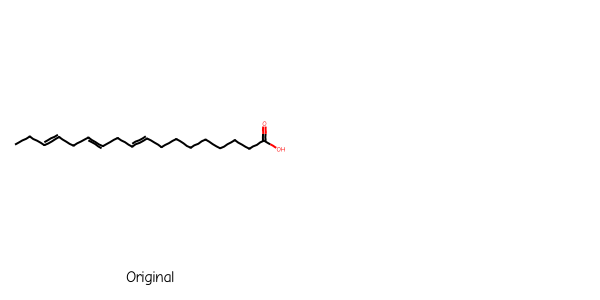

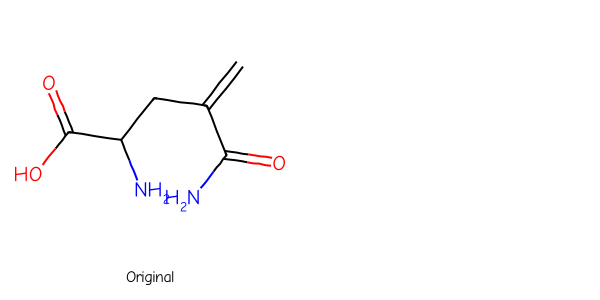

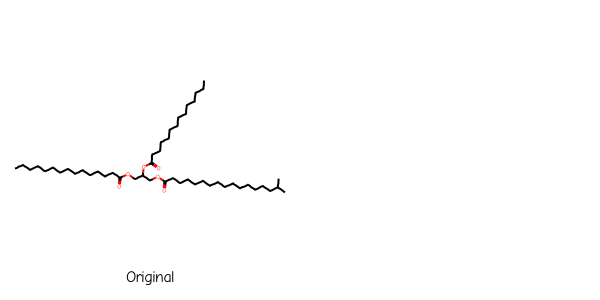

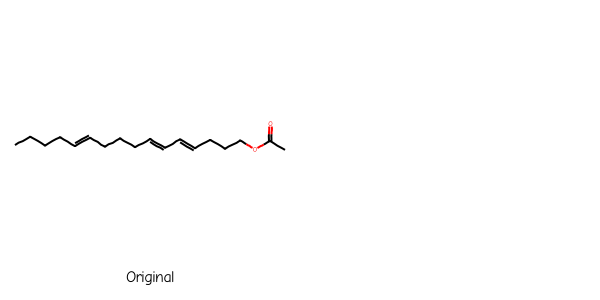

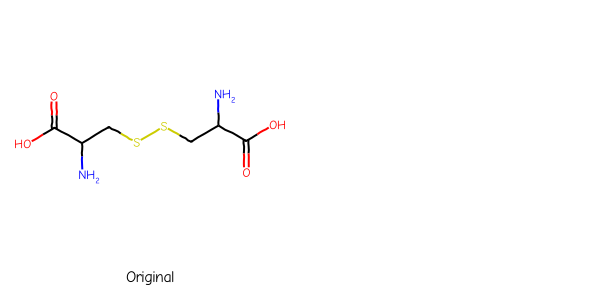

In [135]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Scaffolds import MurckoScaffold
from IPython.display import display, Image, HTML
# Assuming 'df' is your DataFrame with 'smiles' and 'scaffold_smiles' columns

# Extract molecules with empty scaffolds
empty_scaffold_df = df[df['scaffold_smiles'] == '']

# Print the number of molecules with empty scaffolds
print(f"Number of molecules with empty scaffolds: {len(empty_scaffold_df)}")

# Extract 5 random molecules with empty scaffolds
sample_empty_scaffolds = empty_scaffold_df.sample(n=min(5, len(empty_scaffold_df)))

def display_molecule_and_scaffold(smiles, scaffold_smiles):
    mol = Chem.MolFromSmiles(smiles)
    scaffold_mol = Chem.MolFromSmiles(scaffold_smiles) if scaffold_smiles != "Invalid SMILES" else None
    
    img = Draw.MolsToGridImage(
        [mol, scaffold_mol] if scaffold_mol else [mol],
        molsPerRow=2,
        subImgSize=(300, 300),
        legends=['Original', 'Scaffold'] if scaffold_mol else ['Original']
    )
    
    display(img)
    display(HTML(f"<b>Original SMILES:</b> {smiles}<br><b>Scaffold SMILES:</b> {scaffold_smiles}"))
    display(HTML("<hr>"))

# Assuming sample_empty_scaffolds is your DataFrame with molecules that have empty scaffolds
print("Sample molecules with empty scaffolds:")
for idx, row in sample_empty_scaffolds.iterrows():
    smiles = row['smiles']
    scaffold_smiles = row['scaffold_smiles']
    
    display(HTML(f"<h3>Molecule {idx}</h3>"))
    display_molecule_and_scaffold(smiles, scaffold_smiles)


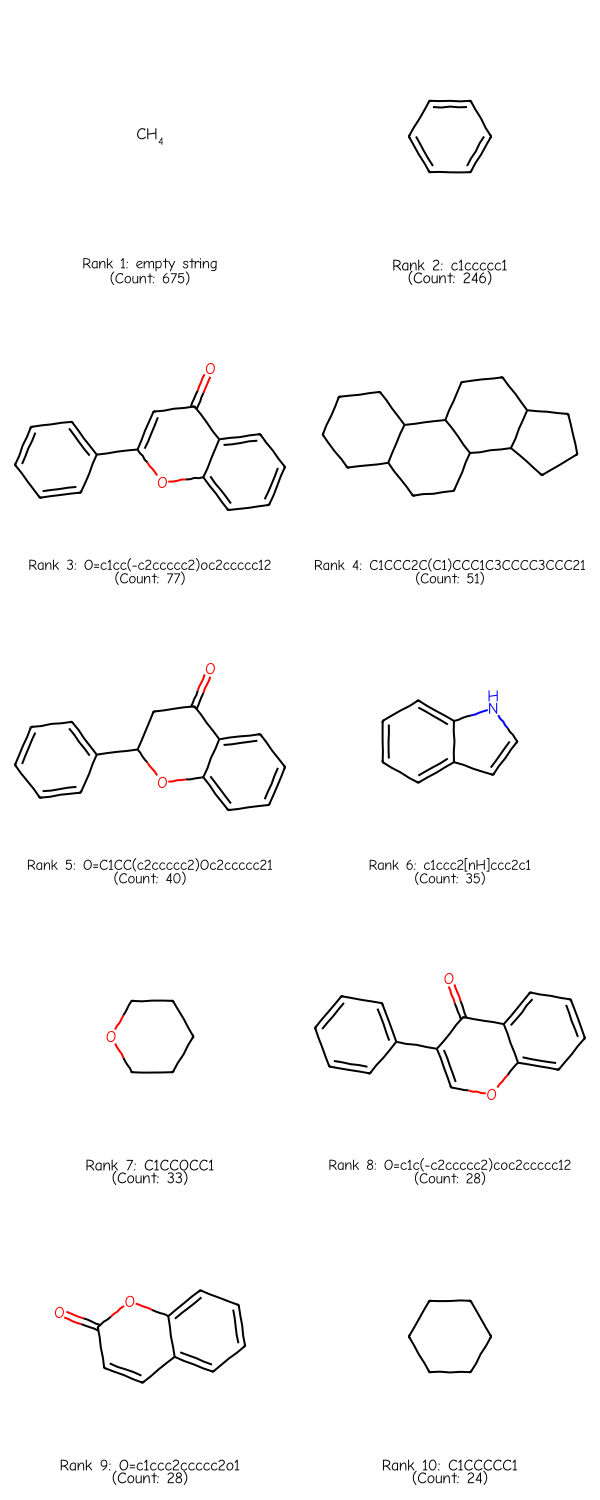

Scaffold visualization saved as 'scaffold_visualization_ranked.png'

Top Scaffolds by Frequency:
Rank 1: empty string (Count: 675)
Rank 2: c1ccccc1 (Count: 246)
Rank 3: O=c1cc(-c2ccccc2)oc2ccccc12 (Count: 77)
Rank 4: C1CCC2C(C1)CCC1C3CCCC3CCC21 (Count: 51)
Rank 5: O=C1CC(c2ccccc2)Oc2ccccc21 (Count: 40)
Rank 6: c1ccc2[nH]ccc2c1 (Count: 35)
Rank 7: C1CCOCC1 (Count: 33)
Rank 8: O=c1c(-c2ccccc2)coc2ccccc12 (Count: 28)
Rank 9: O=c1ccc2ccccc2o1 (Count: 28)
Rank 10: C1CCCCC1 (Count: 24)


In [136]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display, Image as IPythonImage
from PIL import Image as PILImage
import io
from collections import Counter

# Assuming df_sorted is your pandas DataFrame with 'smiles' and 'scaffold_smiles' columns

# Count scaffold frequencies, including empty strings
scaffold_counts = Counter(df_sorted['scaffold_smiles'].fillna(''))

# Sort scaffolds by frequency
sorted_scaffolds = sorted(scaffold_counts.items(), key=lambda x: x[1], reverse=True)

# Convert top scaffold SMILES to RDKit molecules
num_to_visualize = min(10, len(sorted_scaffolds))
valid_scaffs = []
legends = []

for rank, (smi, count) in enumerate(sorted_scaffolds[:num_to_visualize], 1):
    if smi == '':
        valid_scaffs.append(Chem.MolFromSmiles('C'))  # Placeholder molecule for empty string
        legends.append(f"Rank {rank}: empty string\n(Count: {count})")
    else:
        mol = Chem.MolFromSmiles(smi)
        if mol is not None:
            valid_scaffs.append(mol)
            legends.append(f"Rank {rank}: {smi}\n(Count: {count})")

# Create grid image
img = Draw.MolsToGridImage(
    valid_scaffs,
    molsPerRow=2,  # Reduced to 2 per row to accommodate longer legends
    subImgSize=(300, 300),  # Increased size
    legends=legends,
    returnPNG=False  # This returns a PIL Image object
)

# Convert PIL Image to bytes
img_byte_arr = io.BytesIO()
img.save(img_byte_arr, format='PNG')
img_byte_arr = img_byte_arr.getvalue()

# Display the image directly in the notebook
display(IPythonImage(data=img_byte_arr))

# If you want to save the image to a file:
with open("scaffold_visualization_ranked.png", "wb") as f:
    f.write(img_byte_arr)
print(f"Scaffold visualization saved as 'scaffold_visualization_ranked.png'")

# Print SMILES for displayed scaffolds
print("\nTop Scaffolds by Frequency:")
for rank, (smi, count) in enumerate(sorted_scaffolds[:num_to_visualize], 1):
    if smi == '':
        print(f"Rank {rank}: empty string (Count: {count})")
    else:
        print(f"Rank {rank}: {smi} (Count: {count})")

Scaffold distribution plot saved as 'scaffold_distribution.png'


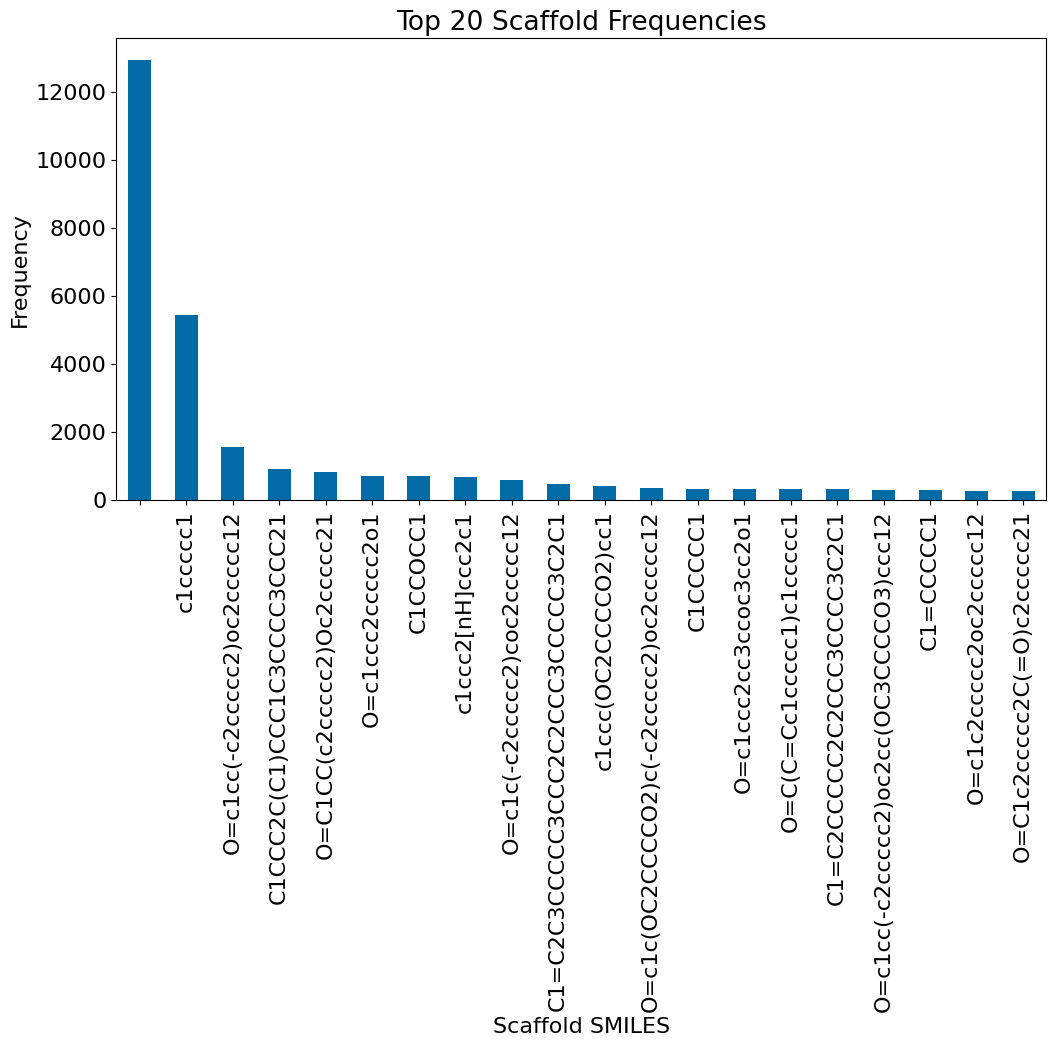

In [138]:
# Count scaffold frequencies
scaffold_counts = pd.Series(scaff_smis).value_counts()

# Plot scaffold distribution
plt.figure(figsize=(12, 6))
scaffold_counts.head(20).plot(kind="bar")
plt.title("Top 20 Scaffold Frequencies")
plt.xlabel("Scaffold SMILES")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
# plt.tight_layout()
plt.savefig("scaffold_distribution.png")

print("Scaffold distribution plot saved as 'scaffold_distribution.png'")